# ECommerce Text Classification

Loading the Dataset from Kaggle

In [1]:
!pip install opendatasets
!pip install pandas

In [2]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mainak0907
Your Kaggle Key: ··········


100%|██████████| 7.86M/7.86M [00:00<00:00, 48.1MB/s]

GRU Implementation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from itertools import chain
import re
from tensorflow.keras.preprocessing.text import one_hot
from yellowbrick.classifier import ROCAUC
import unicodedata
from gensim.models.fasttext import FastText
from sklearn.metrics import roc_curve,auc, roc_auc_score, cohen_kappa_score, brier_score_loss
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
import tensorflow as tf
from itertools import cycle
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df=pd.read_csv("/content/ecommerce-text-classification/ecommerceDataset.csv",names=["label","text"])
df.head()

,label,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [5]:
df.shape

(50425, 2)

In [6]:
df.isnull().sum()


label    0
text     1
dtype: int64

In [7]:
df.dropna(inplace=True)


In [8]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [9]:
df.label.value_counts()

Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8670
Name: label, dtype: int64

<ipython-input-10-8f08e34c66f2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="label", data=df, palette="tab10")


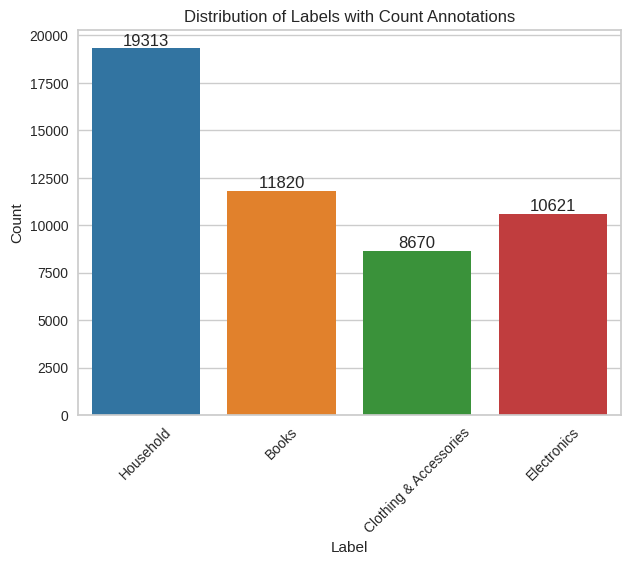

In [10]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x="label", data=df, palette="tab10")

for p in ax.patches:
    ax.annotate('{}'.format(int(p.get_height())), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels with Count Annotations")
plt.xticks(rotation=45)
plt.show()

In [11]:
label_encoder = LabelEncoder()
df['t_label'] = label_encoder.fit_transform(df['label'])
df.head()

,label,text,t_label
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,3
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Household,Incredible Gifts India Wooden Happy Birthday U...,3


In [12]:
df['decoded_category'] = label_encoder.inverse_transform(df['t_label'])
print(df[['label', 't_label', 'decoded_category']])


             label  t_label decoded_category
0        Household        3        Household
1        Household        3        Household
2        Household        3        Household
3        Household        3        Household
4        Household        3        Household
...            ...      ...              ...
50420  Electronics        2      Electronics
50421  Electronics        2      Electronics
50422  Electronics        2      Electronics
50423  Electronics        2      Electronics
50424  Electronics        2      Electronics

[50424 rows x 3 columns]


In [13]:
df[['label', 't_label', 'decoded_category']].value_counts()

label                   t_label  decoded_category      
Household               3        Household                 19313
Books                   0        Books                     11820
Electronics             2        Electronics               10621
Clothing & Accessories  1        Clothing & Accessories     8670
dtype: int64

In [14]:
df.drop(["label","decoded_category"],axis=1,inplace=True)

In [15]:
df.head()

,text,t_label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",3
2,SAF 'UV Textured Modern Art Print Framed' Pain...,3
3,"SAF Flower Print Framed Painting (Synthetic, 1...",3
4,Incredible Gifts India Wooden Happy Birthday U...,3


In [16]:
df2=df.copy()

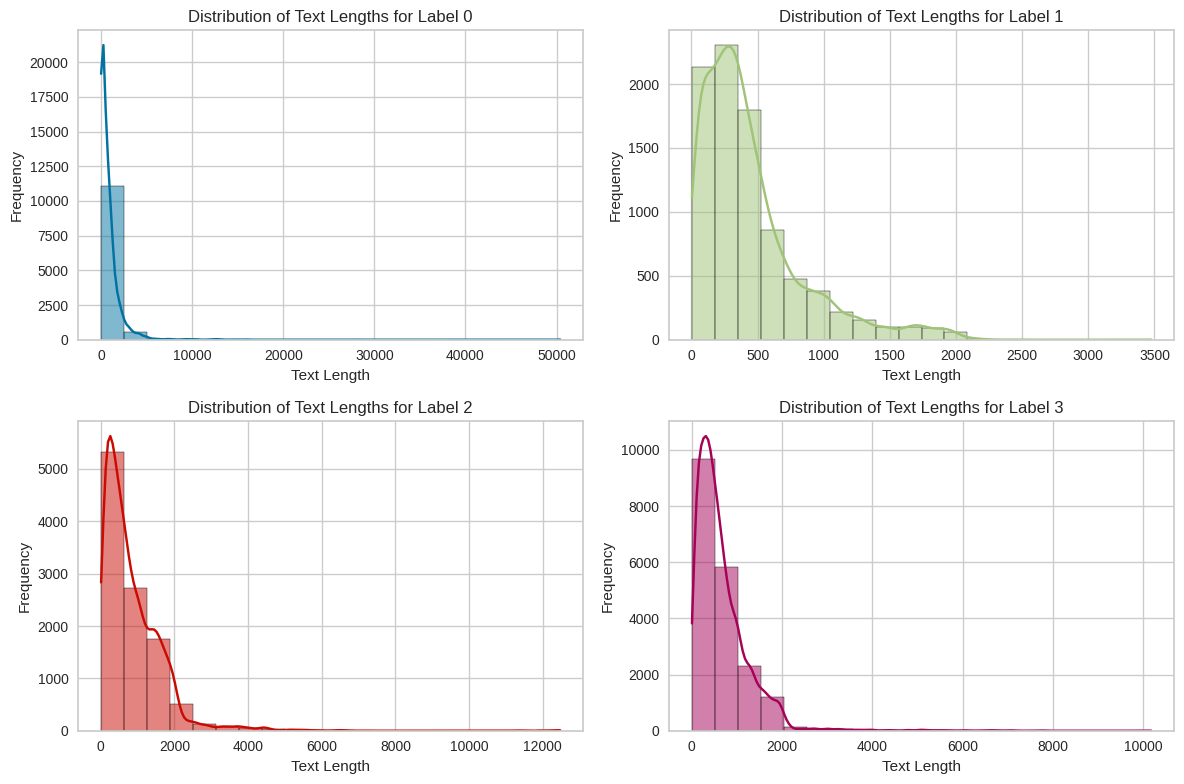

In [17]:
b_len=df[df["t_label"]==0]["text"].str.len()
c_len=df[df["t_label"]==1]["text"].str.len()
e_len=df[df["t_label"]==2]["text"].str.len()
h_len=df[df["t_label"]==3]["text"].str.len()


fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for label, ax in zip(range(4), axes):
    text_lengths = df[df["t_label"] == label]["text"].str.len()
    sns.histplot(text_lengths, bins=20, color=sns.color_palette()[label], ax=ax, kde=True)

    ax.set_title(f'Distribution of Text Lengths for Label {label}')
    ax.set_xlabel('Text Length')
    ax.set_ylabel('Frequency')
    ax.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-18-1f3a9dcb972b>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)


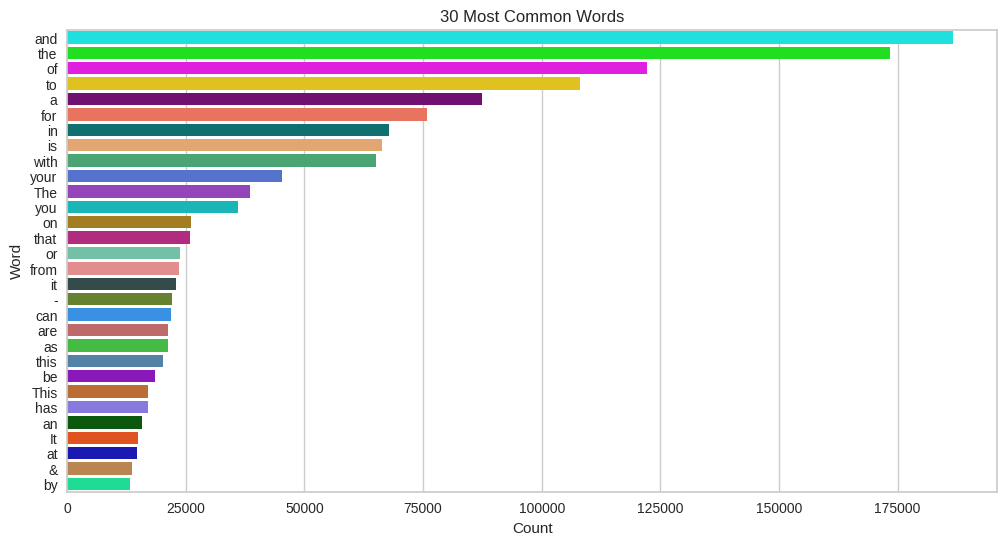

In [18]:
data_set =df["text"].str.split()
all_words = list(chain.from_iterable(data_set))
counter = Counter(all_words)
common_words = counter.most_common(30)
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])

colors = ["cyan", "lime", "magenta", "gold", "purple", "tomato", "teal", "sandybrown", "mediumseagreen",
          "royalblue", "darkorchid", "darkturquoise", "darkgoldenrod", "mediumvioletred", "mediumaquamarine",
          "lightcoral", "darkslategray", "olivedrab", "dodgerblue", "indianred", "limegreen", "steelblue",
          "darkviolet", "chocolate", "mediumslateblue", "darkgreen", "orangered", "mediumblue", "peru", "mediumspringgreen"]

plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=df_common_words, palette=colors)
plt.title('30 Most Common Words')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

Data Cleaning


In [19]:
df["text"][100]

'Embroidery Kit for Beginners DIY Kit Total 15 Iteam This embroidery kit is consists of all the basic items that a beginner will require to learn embroidery. This kit can also be a perfect gift for your loved ones.'

In [20]:
from nltk.corpus import stopwords
def clean_text(text):

    # Remove HTML tags if present
    if "<" in text:
        text = BeautifulSoup(text, 'html.parser').get_text()

    # Remove URL addresses
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove accented characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Remove punctuation
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)

    # Remove irrelevant characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    text = ' '.join(filtered_words)

    return text

In [21]:
df["text"] = df["text"].apply(clean_text)

In [22]:
df["text"][100]

'Embroidery Kit Beginners DIY Kit Total Iteam embroidery kit consists basic items beginner require learn embroidery kit also perfect gift loved ones'

In [23]:
avg_len=df["text"].str.len().mean()
print("Average text length :",avg_len)

Average text length : 526.3738299222592


In [24]:
df.head()

,text,t_label
0,Paper Plane Design Framed Wall Hanging Motivat...,3
1,SAF Floral Framed Painting Wood inch x inch Sp...,3
2,SAF UV Textured Modern Art Print Framed Painti...,3
3,SAF Flower Print Framed Painting Synthetic inc...,3
4,Incredible Gifts India Wooden Happy Birthday U...,3


Term frequency Inverse document frequency (TFIDF) Vectorization

In [25]:
text_data=df["text"]
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(text_data)

print("TF-IDF Matrix (sparse representation):\n", tfidf_matrix)

TF-IDF Matrix (sparse representation):
   (0, 50078)	0.049141666511018166
  (0, 15822)	0.05430081452610637
  (0, 24557)	0.08030983242477319
  (0, 14654)	0.0773190433286306
  (0, 29638)	0.09589890529476239
  (0, 44276)	0.05249300307568595
  (0, 33970)	0.10329948088455969
  (0, 48051)	0.08567925105863314
  (0, 34513)	0.10396552901669925
  (0, 64642)	0.11538860471873348
  (0, 22113)	0.0832655258182251
  (0, 60392)	0.10396552901669925
  (0, 20489)	0.05364342028808479
  (0, 22586)	0.060775027809688055
  (0, 18267)	0.07148753223720558
  (0, 52712)	0.07954281015167232
  (0, 40333)	0.07293186987532493
  (0, 11267)	0.05447064248145778
  (0, 49570)	0.05981090954675647
  (0, 34611)	0.13211144996694485
  (0, 18269)	0.05444331635267689
  (0, 26859)	0.07617390719659597
  (0, 7390)	0.06018134148119096
  (0, 6272)	0.10148897005441766
  (0, 19443)	0.10206415967969071
  :	:
  (50422, 1709)	0.04171046651891545
  (50422, 58766)	0.08547948780119431
  (50422, 11370)	0.0480123440351555
  (50422, 24646)	0.025

In [26]:
vocabulary =tfidf.get_feature_names_out()
print("Vocabulary:", vocabulary)

Vocabulary: ['aa' 'aaa' 'aaaa' ... 'zz' 'zzy' 'zzzzs']


In [27]:
label_data=df["t_label"]

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf_matrix, label_data, test_size=0.2, random_state=42)


In [29]:
model = MultinomialNB()
model.fit(X_train, Y_train)


MultinomialNB()

In [30]:
pred=model.predict(X_test)
accuracy = accuracy_score(Y_test, pred)
print("Accuracy:", accuracy)

Accuracy: 0.9438770451165097


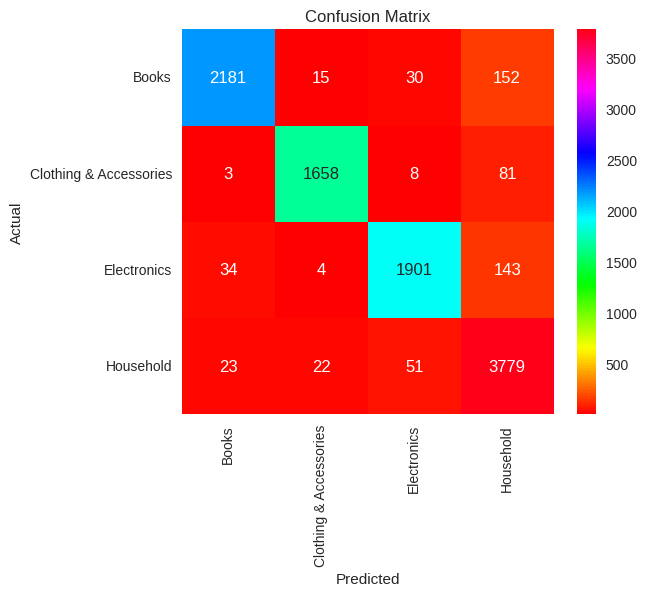

In [31]:
label_name=["Books","Clothing & Accessories","Electronics","Household"]
cf=confusion_matrix(Y_test,pred)
plt.figure(figsize=(6,5))
sns.heatmap(cf,annot=True,fmt="d",cmap="hsv",xticklabels=label_name,yticklabels=label_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [32]:
print(classification_report(Y_test,pred,target_names=label_name))

                        precision    recall  f1-score   support

                 Books       0.97      0.92      0.94      2378
Clothing & Accessories       0.98      0.95      0.96      1750
           Electronics       0.96      0.91      0.93      2082
             Household       0.91      0.98      0.94      3875

              accuracy                           0.94     10085
             macro avg       0.95      0.94      0.95     10085
          weighted avg       0.95      0.94      0.94     10085



In [33]:
Y_test.shape

(10085,)

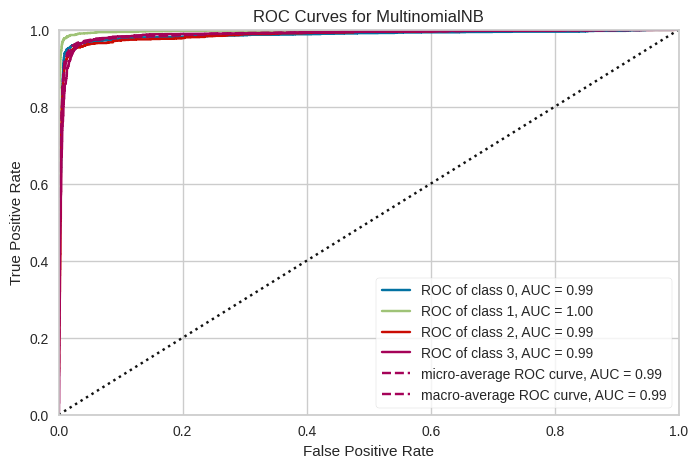

<Axes: title={'center': 'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [34]:
plt.figure(figsize=(8,5))
visualizer = ROCAUC(model, classes=[0, 1, 2, 3])
visualizer.fit(X_train, Y_train)
visualizer.score(X_test, Y_test)
visualizer.show()

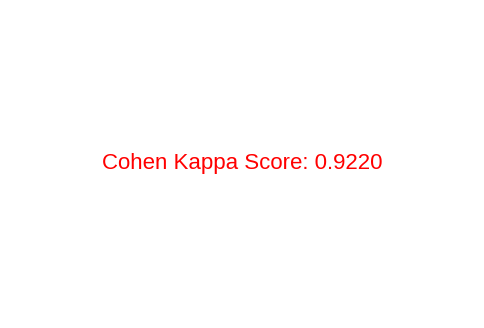

In [35]:
kappa = cohen_kappa_score(Y_test,pred)
plt.figure(figsize=(6,4))
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="red")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

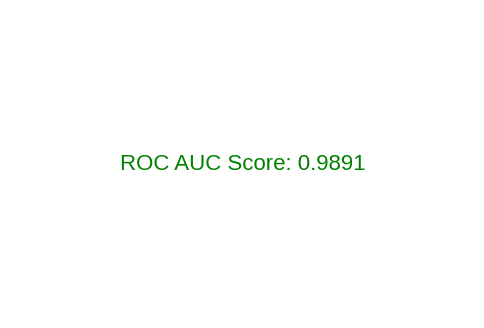

In [36]:
y_prob = model.predict_proba(X_test)

roc_auc = roc_auc_score(Y_test,y_prob, multi_class='ovr')
plt.figure(figsize=(6,4))
plt.plot([])

plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="green")
plt.axis('off')

plt.xlim(-1, 1)
plt.ylim(-1, 1)


plt.show()

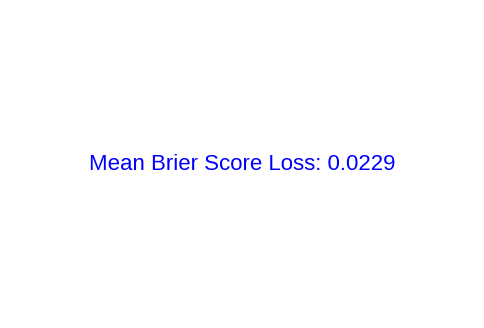

In [37]:
brier_loss_per_class = [brier_score_loss((Y_test == c).astype(int),y_prob[:, c]) for c in range(y_prob.shape[1])]
mean_brier_loss = np.mean(brier_loss_per_class)
plt.figure(figsize=(6, 4))
plt.plot([])
plt.text(0, 0, f'Mean Brier Score Loss: {mean_brier_loss:.4f}', fontsize=16, ha='center', va='center', color="blue")
plt.axis('off')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

Fasttext With Skipgram


In [38]:
max_len=500
text_list =df["text"].str.split().tolist()
my_label=df["t_label"].values

In [39]:
fasttext_model = FastText(text_list, vector_size=100, window=5, min_count=1, workers=4, sg=1)

In [40]:
fasttext_model.wv['king']


array([-0.11983635,  0.42353925, -0.44701636,  0.1996091 , -0.21619572,
        1.0603687 , -0.13579115,  0.6260342 ,  0.07958052, -0.69424254,
        0.06538297, -0.46056792,  0.3715766 , -0.38125837,  0.33806825,
        1.3200799 ,  0.62356716, -0.71745354, -0.2139507 , -0.42689896,
       -0.69033074,  0.05107604,  0.3788072 , -0.04739229, -0.6966557 ,
       -1.5146309 , -0.8302767 ,  0.23962213,  0.01795015, -0.78641057,
       -0.28560683,  0.67923933,  0.53642213, -0.21897465, -0.4202879 ,
        0.90173155,  0.942796  ,  0.03723681, -0.7257898 , -1.0210347 ,
        0.06306316,  0.51296526, -0.5039743 , -0.633461  , -0.09918146,
        0.17565045, -0.7485979 ,  0.1520799 , -0.33154213,  0.40983036,
        0.3961538 ,  0.97613615,  0.4295189 ,  0.02086633,  0.5993585 ,
       -0.6739122 ,  1.1384759 ,  0.27450353, -0.17251296, -0.2216434 ,
       -0.06008793, -0.08465839,  0.26966402, -0.05388373, -0.45954645,
        0.62769943,  0.3681657 , -0.61873305,  0.26100934,  0.53

In [41]:
fasttext_model.wv['king'].shape

(100,)

In [42]:
fasttext_model.wv.most_similar('wife', topn=10)

[('midwife', 0.8123195171356201),
 ('husband', 0.7985997796058655),
 ('husbandry', 0.7855607867240906),
 ('daughters', 0.7729358077049255),
 ('granddaughter', 0.7722200751304626),
 ('husbands', 0.7505624294281006),
 ('husbandat', 0.7504514455795288),
 ('livesand', 0.7422091364860535),
 ('daughter', 0.7317777872085571),
 ('CaliforniaMary', 0.7213484644889832)]

In [43]:
fasttext_model.wv.similarity('beer', 'drink')

0.4693511

In [44]:
fasttext_model.wv.most_similar(negative=["cat"], topn=10)

[('Def', 0.3544507920742035),
 ('Masq', 0.3147326111793518),
 ('Em', 0.3099268078804016),
 ('Pr', 0.3092142939567566),
 ('Ref', 0.30825528502464294),
 ('Dy', 0.3078524172306061),
 ('DegC', 0.30174800753593445),
 ('ProFXv', 0.29592257738113403),
 ('Acc', 0.28752416372299194),
 ('PreK', 0.2837475538253784)]

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_list)
text_seq=tokenizer.texts_to_sequences(text_list)
pad_seq=pad_sequences(text_seq,maxlen=max_len)

In [46]:
vocab_size=len(fasttext_model.wv.key_to_index)
vocab=tokenizer.word_index
print("Vocab Size :",vocab_size)
# print(vocab)

Vocab Size : 90735


In [47]:
embedding_matrix = fasttext_model.wv.vectors
embedding_matrix.shape

(90735, 100)

One Hot


In [48]:
texts = df['text']
one_hot_texts = [one_hot(text,vocab_size) for text in texts]
df['text'] = one_hot_texts

print(df.head())

                                                text  t_label
0  [42739, 18504, 43678, 2194, 59087, 56018, 2534...        3
1  [72757, 86084, 2194, 66098, 60696, 56013, 9059...        3
2  [72757, 51287, 11352, 28021, 65840, 19085, 219...        3
3  [72757, 19358, 19085, 2194, 66098, 89971, 5601...        3
4  [89466, 72416, 86561, 47560, 51794, 36664, 468...        3


In [49]:
my_onehot_data=df["text"]
embedded_doc=pad_sequences(my_onehot_data,padding='pre',maxlen=max_len)
embedded_doc

array([[    0,     0,     0, ..., 26420, 77316, 60698],
       [    0,     0,     0, ..., 46011, 50425, 63228],
       [    0,     0,     0, ..., 72841, 23872, 36565],
       ...,
       [    0,     0,     0, ..., 83261, 31068, 42466],
       [    0,     0,     0, ..., 21202, 68431, 47467],
       [    0,     0,     0, ..., 49546, 54792, 75056]], dtype=int32)

In [50]:
my_text=np.array(embedded_doc)
y=df["t_label"]
my_label=np.array(y)

In [51]:
X_train0, X_test0, Y_train0, Y_test0 = train_test_split(my_text,my_label, test_size=0.2, random_state=42)

In [52]:
print("Train text Data shape :",X_train0.shape)
print("====================================================")
print("Test text Data shape :",X_test0.shape)
print("====================================================")
print("Train label Data shape :",Y_train0.shape)
print("====================================================")
print("Train label Data shappendape :",Y_test0.shape)

Train text Data shape : (40339, 500)
Test text Data shape : (10085, 500)
Train label Data shape : (40339,)
Train label Data shappendape : (10085,)


GRU Model

In [53]:
embedding_dim=100
model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_len))
model2.add(GRU(units=128, activation="tanh"))
model2.add(Dropout(0.3))
model2.add(Dense(4, activation='softmax'))
model2.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          9073500   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 9162336 (34.95 MB)
Trainable params: 9162336 (34.95 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
history = model2.fit(X_train0, Y_train0, validation_data=(X_test0, Y_test0), epochs=10, batch_size=32)

Epoch 1/10
1261/1261 [==============================] - 164s 127ms/step - loss: 0.3437 - accuracy: 0.8784 - val_loss: 0.1280 - val_accuracy: 0.9659
Epoch 2/10
1261/1261 [==============================] - 70s 55ms/step - loss: 0.0834 - accuracy: 0.9784 - val_loss: 0.1129 - val_accuracy: 0.9698
Epoch 3/10
1261/1261 [==============================] - 49s 39ms/step - loss: 0.0407 - accuracy: 0.9898 - val_loss: 0.0883 - val_accuracy: 0.9790
Epoch 4/10
1261/1261 [==============================] - 44s 35ms/step - loss: 0.0254 - accuracy: 0.9931 - val_loss: 0.0960 - val_accuracy: 0.9797
Epoch 5/10
1261/1261 [==============================] - 35s 28ms/step - loss: 0.0168 - accuracy: 0.9956 - val_loss: 0.0812 - val_accuracy: 0.9801
Epoch 6/10
1261/1261 [==============================] - 34s 27ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0903 - val_accuracy: 0.9823
Epoch 7/10
1261/1261 [==============================] - 32s 26ms/step - loss: 0.0086 - accuracy: 0.9977 - val_loss: 0.0957

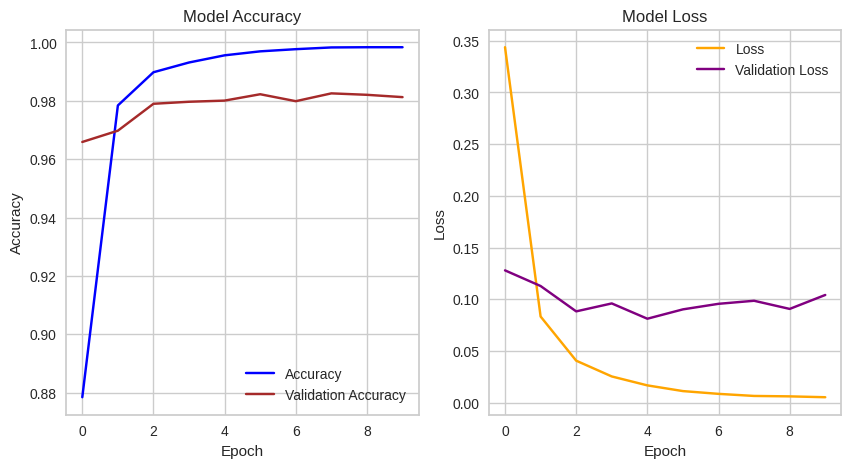

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# First subplot
ax[0].plot(history.history['accuracy'],label="Accuracy",color="blue")
ax[0].plot(history.history['val_accuracy'],label="Validation Accuracy",color="brown")
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='best')

# Second subplot
ax[1].plot(history.history['loss'],label="Loss",color="orange")
ax[1].plot(history.history['val_loss'],label="Validation Loss",color="purple")
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='best')

plt.show()

In [56]:
pred2=model2.predict(X_test0)
final_predict=np.argmax(pred2,axis=1)

316/316 [==============================] - 3s 8ms/step


Confusion Matrix

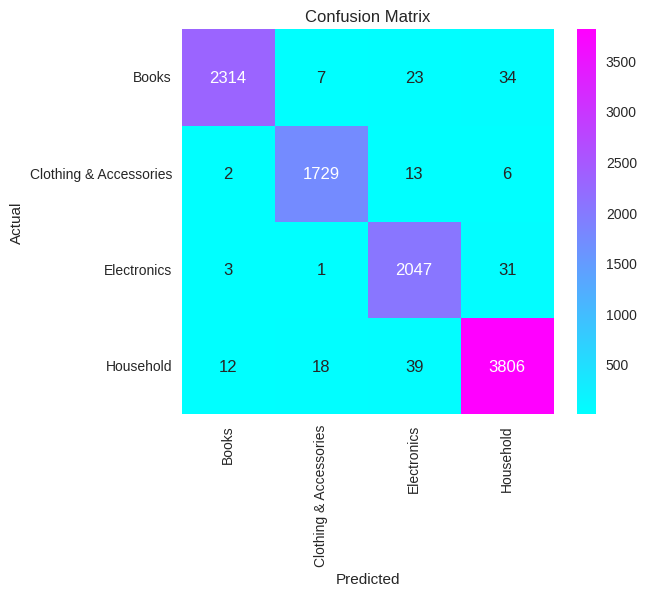

In [57]:
label_name=["Books","Clothing & Accessories","Electronics","Household"]
cf=confusion_matrix(Y_test0,final_predict)
plt.figure(figsize=(6,5))
sns.heatmap(cf,annot=True,fmt="d",cmap="cool",xticklabels=label_name,yticklabels=label_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Classification


In [58]:
print(classification_report(Y_test0,final_predict,target_names=label_name))

                        precision    recall  f1-score   support

                 Books       0.99      0.97      0.98      2378
Clothing & Accessories       0.99      0.99      0.99      1750
           Electronics       0.96      0.98      0.97      2082
             Household       0.98      0.98      0.98      3875

              accuracy                           0.98     10085
             macro avg       0.98      0.98      0.98     10085
          weighted avg       0.98      0.98      0.98     10085



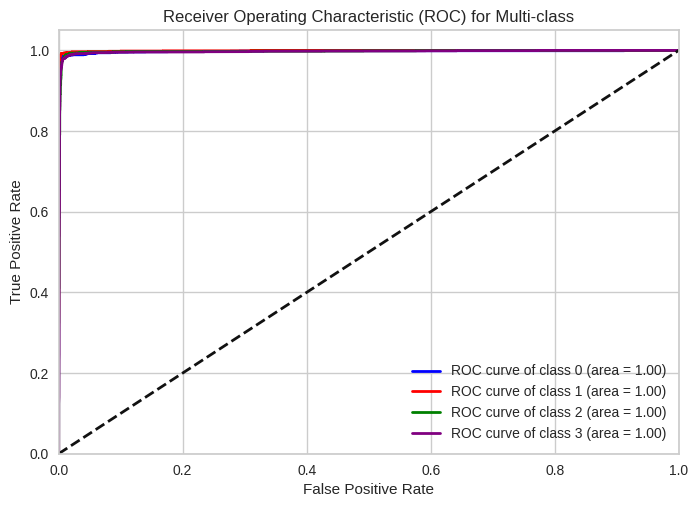

In [59]:
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test0 == i, pred2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])  # Add more colors as needed
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-class')
plt.legend(loc="lower right")
plt.show()

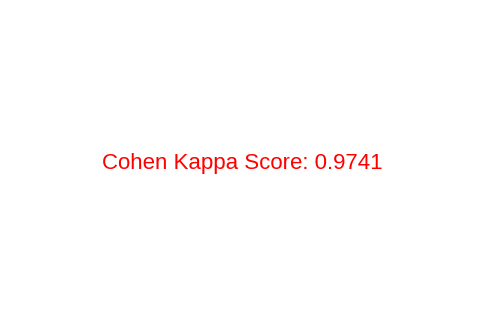

In [60]:
kappa = cohen_kappa_score(Y_test0,final_predict)
plt.figure(figsize=(6,4))
plt.plot([])
plt.text(0,0, f'Cohen Kappa Score: {kappa:.4f}', fontsize=16, ha='center', va='center',color="red")
plt.axis('off')

# Set the x-axis limits
plt.xlim(-1, 1)
plt.ylim(-1,1)

plt.show()

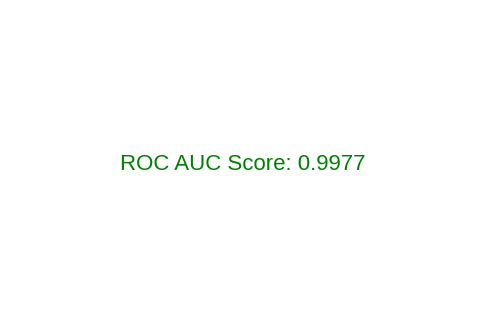

In [61]:
roc_auc = roc_auc_score(Y_test0,pred2, multi_class='ovr')
plt.figure(figsize=(6,4))
plt.plot([])

plt.text(0, 0, f'ROC AUC Score: {roc_auc:.4f}', fontsize=16, ha='center', va='center', color="green")
plt.axis('off')

plt.xlim(-1, 1)
plt.ylim(-1, 1)


plt.show()

316/316 [==============================] - 2s 8ms/step


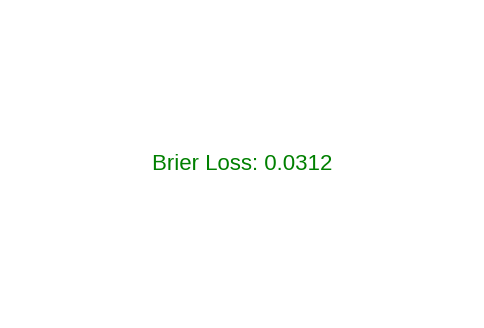

In [62]:
pred_probabilities = model2.predict(X_test0)
one_hot_true = np.zeros_like(pred_probabilities)
one_hot_true[np.arange(len(Y_test)), Y_test] = 1
brier_loss = np.mean(np.sum((pred_probabilities - one_hot_true)**2, axis=1))
plt.figure(figsize=(6,4))
plt.plot([])

plt.text(0, 0, f'Brier Loss: {brier_loss:.4f}', fontsize=16, ha='center', va='center', color="green")
plt.axis('off')

plt.xlim(-1, 1)
plt.ylim(-1, 1)


plt.show()

Prediction on Custom Text

In [63]:
df2[df2["t_label"]==3]["text"].head(20)[19]

'ART DIOR | Dancing Village Girls | Canvas Wall Art | Unframed Canvas Art Print | 18 inch x 46 inch | Enclosure Material:Canvas Art Print                                                                                \xa0|\xa0                           Size:18" x 46" Art Print Only   Giclée art from Creative team of Art Dior. Printed by dedicated art printer on Epson 9900 on very specialized coated canvas to bring out brush stroke details, brilliance of colors, dimensional stability and lasting colors for archival use. Add soul to your walls, add volumes of euphoric feel once properly framed and displayed on Living, Drawing & Dining Room, Gallery, Hotels, Bar, Lounge, Restaurants, Office, Reception, Kitchen Area, Bathroom. Packed with utmost care for mint fresh condition delivery. Art prints are of very specialized fine ink quality and color gamut to maintain color depth and brilliance, direct sunlight should be avoided. Please confirm size before placing any order. TERMS & CONDITIONS 

In [64]:
custom_texts = ["Path of Meditation: A Step-by-step Guide to Meditation The culture that will arise in the future, if it is truly to be for the evolution of mankind, will be a balance of science and religion. This culture will be a synthesis of religion and science. It will not be only religious or only scientific: it will be either scientifically religious or religiously scientific Osho The talks in this book are transcriptions of a meditation program led by Osho in the beautiful hills of Mahabaleshwar. It is a step by step account of how to prepare the body, mind and emotions to enhance your meditation. Osho guides the participants and the reader alike in the use of powerful meditation techniques and suggests many useful applications for supporting meditation in your daily life. He also describes the different stages that happen on the path of meditation. This book is a must-read for both the new and the experienced meditator. Even more, it is an invitation to experiment with these life-transformi"]
custom_one_hot_texts = [one_hot(text, vocab_size) for text in custom_texts]
custom_embedded_doc = pad_sequences(custom_one_hot_texts, padding='pre', maxlen=max_len)

custom_predictions = model2.predict(custom_embedded_doc)

predicted_classes = np.argmax(custom_predictions, axis=1)
class_probabilities = np.max(custom_predictions, axis=1)

for i in range(len(custom_texts)):
    print(f"Predicted Class: {predicted_classes[i]}, Probability: {class_probabilities[i]}")

1/1 [==============================] - 0s 59ms/step
Predicted Class: 0, Probability: 0.995012104511261


In [65]:

custom_texts = ["ART DIOR | Dancing Village Girls | Canvas Wall Art | Unframed Canvas Art Print | 18 inch x 46 inch | Enclosure Material:Canvas Art Print\xa0|\xa0 Size:18 x 46 Art Print Only   Giclée art from Creative team of Art Dior. Printed by dedicated art printer on Epson 9900 on very specialized coated canvas to bring out brush stroke details, brilliance of colors, dimensional stability and lasting colors for archival use. Add soul to your walls, add volumes of euphoric feel once properly framed and displayed on Living, Drawing & Dining Room, Gallery, Hotels, Bar, Lounge, Restaurants, Office, Reception, Kitchen Area, Bathroom. Packed with utmost care for mint fresh condition delivery. Art prints are of very specialized fine ink quality and color gamut to maintain color depth and brilliance, direct sunlight should be avoided. Please confirm size before placing any order. TERMS & CONDITIONS B"]
custom_one_hot_texts = [one_hot(text, vocab_size) for text in custom_texts]
custom_embedded_doc = pad_sequences(custom_one_hot_texts, padding='pre', maxlen=max_len)

custom_predictions = model2.predict(custom_embedded_doc)

predicted_classes = np.argmax(custom_predictions, axis=1)
if predicted_classes==3:
  print("Household")
else:
  print("Others")

class_probabilities = np.max(custom_predictions, axis=1)

for i in range(len(custom_texts)):
    print(f"Predicted Class: {predicted_classes[i]}, Probability: {class_probabilities[i]}")

1/1 [==============================] - 0s 23ms/step
Household
Predicted Class: 3, Probability: 0.9999386072158813
